In [1]:
import rioxarray
import rasterio
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from geomod import predictor
from geomod import utils

### Preparing the Data

In [3]:
data_directory = '/home/jovyan/PlanetaryComputerExamples/adv-python-final/geomod/example-notebooks/data/'

In [4]:
driver_map_names = ['elevation01', 'geology01', 'protection01']
driver_map_paths = [data_directory+name+'.rst' for name in driver_map_names]
driver_map_xr_list = [rioxarray.open_rasterio(map, masked=True) for map in driver_map_paths]
all_driver_maps_xr = xr.concat(driver_map_xr_list, dim='band').assign_coords(band=driver_map_names)

**This package is designed to work best with contininous data**

Given how Geomod categorizes and then generates suitability maps based on driver maps, using purely categorical data will create a suitability map with discrete values. This will cause suitability ties on the desired threshold. Using continous data eliminiates this problem.

Geomod as implemented in Terrset dealt with ties by selecting cells in regular intervals to ensure even distribution across the map. Geomod in this implementation can be configured to take all categorical data by multiplying one band by an extremely small randomly generated noise vector. This results in random selection of tied cells. This is a workaround to all categorical data however, and ideally at least one driver map should be continuous when using Geomod to create a suitability map based on them.

In [5]:
# to deal with the fact that we have all continuous data, we will introduce a random noise vector

band = all_driver_maps_xr.sel(band='elevation01')
# generate random noise array with values between -0.001 and 0, then shift to range 0.99 to 1
noise = np.random.uniform(-0.001, 0, band.shape) + 1.0

# multiply the elevation band by the noise array
all_driver_maps_xr.sel(band='elevation01').data *= noise

In [6]:
# round the driver maps to the nearest integer to get categorical data.
# a future implementation will include the option to categorize driver maps according to user input

all_driver_maps_xr_discrete = all_driver_maps_xr.round().astype('int')

# this is necessary due to rounding not working correctly with nan values
all_driver_maps_xr_discrete = xr.where(all_driver_maps_xr>-1000000, all_driver_maps_xr_discrete, np.nan)


/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [7]:
# import the 1985 classification map, our starting map
input_classification_map_xr = rioxarray.open_rasterio(data_directory+'1985anderson01.rst', masked=True)

In [8]:
# get the metadata from the .RDC that comes with every .rst terrset raster

def get_metadata(rdc_file):
# Open the text file for reading
    metadata_dict = {}
    with open(rdc_file, "r") as file:
    # Read each line in the file
        for line in file:
            # Split each line into key and value using ':'
            key, value = line.strip().split(':')[0:2]
            # Store the key-value pair in the dictionary
            metadata_dict[key.strip()] = value.strip()
    return metadata_dict

In [9]:
# get the metadata for our starting classification map
print(get_metadata(data_directory+'1985anderson01.RDC'))

{'file format': 'IDRISI Raster A.1', 'file title': '1985 Anderson Land Category', 'data type': 'byte', 'file type': 'binary', 'columns': '512', 'rows': '512', 'ref. system': 'spc83ma1', 'ref. units': 'm', 'unit dist.': '1.0000000', 'min. X': '242160.0000000', 'max. X': '257520.0000000', 'min. Y': '923060.0000000', 'max. Y': '938420.0000000', "pos'n error": 'unknown', 'resolution': '30', 'min. value': '0', 'max. value': '7', 'display min': '0', 'display max': '7', 'value units': 'categories', 'value error': 'unknown', 'flag value': '0', "flag def'n": 'background', 'legend cats': '7', 'code      1': 'Built', 'code      2': 'Agriculture', 'code      3': 'Range', 'code      4': 'Forest', 'code      5': 'Water', 'code      6': 'Wetland', 'code      7': 'Barren', 'lineage': '3*C'}


In [10]:
# reclassify the land cover map - we know from the metadata that the class of interest is 1 for built
land_cover_map = utils.reclassify_landcover_map(input_classification_map_xr, class_of_interest=1)

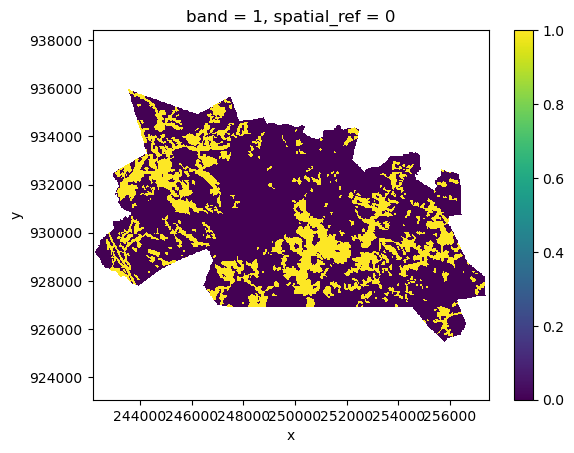

In [11]:
# plot the land cover map, we see the x and y coordinate scale, built areas as 1, all others as 0, and the mask as nan
land_cover_map.plot()

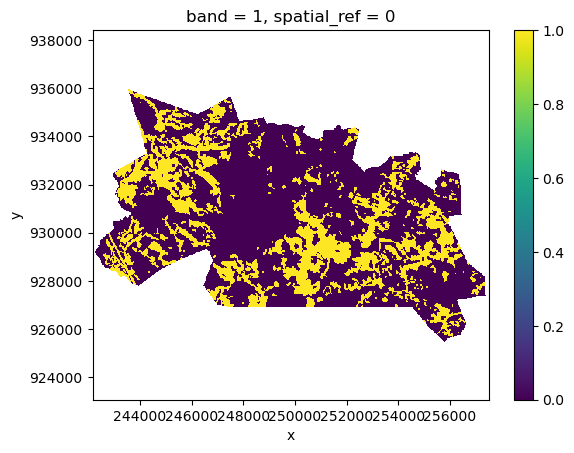

In [12]:
# we do the same with the validation map for the ending time
validation_class_map_xr = rioxarray.open_rasterio(data_directory+'1999anderson01.rst', masked=True)
validation_map = utils.reclassify_landcover_map(validation_class_map_xr, class_of_interest=1)
validation_map.plot()

In [13]:
# users may define weights for each of the driver maps, or use no wieghts for an evenly weighted suitability map
weights = {'elevation01':.2, 'geology01':.2, 'protection01':.6}

In [14]:
# create an example suitability map and an example weighted suitability map with the input maps
# interpolation in this case is the choice of function to interpolate the continuous maps based on their categorical suitability
# in our case, this only effects the continuous elevation01 map
suitability_map = utils.create_suitability_map_xarray(all_driver_maps_xr_discrete, all_driver_maps_xr, land_cover_map, interpolation='linear', weights=weights)
suitability_map_unweighted = utils.create_suitability_map_xarray(all_driver_maps_xr_discrete, all_driver_maps_xr, land_cover_map, interpolation='linear', weights=None)

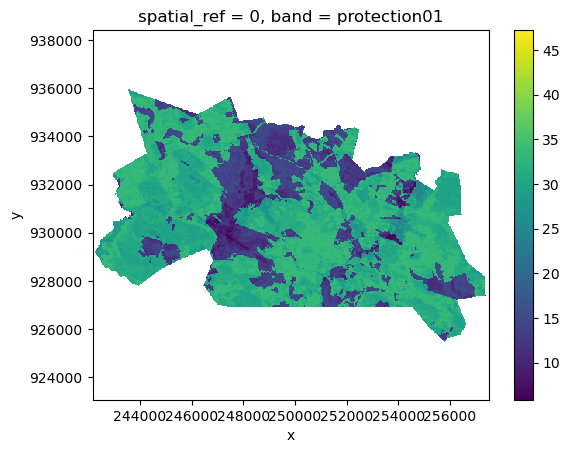

In [15]:
# plot the unweighted suitability map
suitability_map.plot()

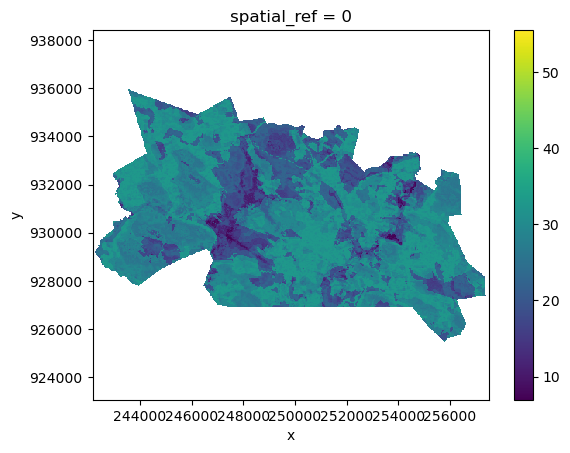

In [16]:
# plot the unweighted suitability map - notice it prioritizes different features
suitability_map_unweighted.plot()

**Perform the GEOMOD prediction unconstrained to a neighborhood**

The section below will incorporated into the Geomod.Predictor.predict() method

In [17]:
# we get the total difference between the validation and land cover map to find the number of pixels we want to change
change_pixel_quantity = validation_map.sum().item() - land_cover_map.sum().item()
print('how many pixels change between steps 1 and 2:', change_pixel_quantity)

how many pixels change between steps 1 and 2: 3159.0


In [18]:
# get a map of suitability only on pixels that are not developed
suitability_change_xr = xr.where(land_cover_map==0, suitability_map_unweighted, np.nan)

In [19]:
# get number of pixels that can be changed
changeable_pixels = xr.where(land_cover_map==0, 1, 0).sum().item()
print('the number of pixels that can be changed:', changeable_pixels)

the number of pixels that can be changed: 75717


In [20]:
# get the threshold above which there are the number of pixels we defined as change_pixel_quantity
suitability_threshold = suitability_change_xr.quantile(q = 1 - (change_pixel_quantity/changeable_pixels), skipna=True).values
print(suitability_threshold)

32.79082696303498


In [21]:
# define which pixels will be changed - only those above the change threshold
change_pixels = xr.where(suitability_change_xr > suitability_threshold, 1, 0)

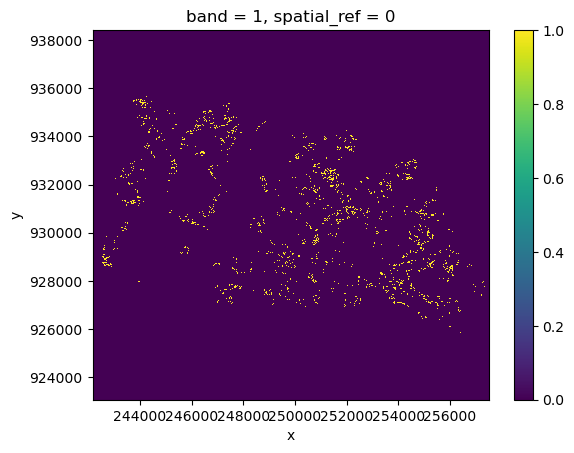

In [22]:
# see the locations of our change pixels
change_pixels.plot()

In [23]:
# find the total number of changed pixels - it should match change_pixel_quantity!
print(change_pixels.sum().item())

3159


In [26]:
# add back on to the orginal map
predicted=land_cover_map+change_pixels

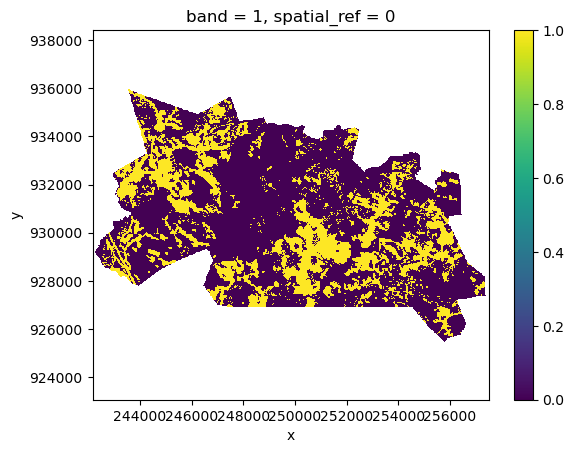

In [27]:
# plot our predicted map
predicted.plot()

## Still to do (12/11):

- write code to generate a crosstab (this is the lowest hanging fruit right now!!)
- use strata to split the region up when analyzing
- implement neighborhood search by iteratively growing the kernel size in calling utils.get_edges()
- start building what's in this notebook into into the Predictor class